In [104]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [105]:
df_fields = pd.read_csv('../data/fields.csv', delimiter=';', decimal=',', skiprows=[0, 2])
df_value = pd.read_csv('../data/value.csv', delimiter=';', decimal=',', skiprows=[0, 1], parse_dates=['inv_item_date'], date_format={'inv_item_date': '%d.%m.%Y'})
df_works = pd.read_csv('../data/works.csv', delimiter=';', decimal=',', skiprows=[0, 1], parse_dates=['start_date', 'end_date'], date_format={'start_date': '%d.%m.%Y', 'end_date': '%d.%m.%Y'})

df_works['area'] = df_works['area'].str.replace(',', '.').astype(float)

# Формирование таблицы с полями и их yield_plan, yield_fact

In [106]:
valid_work_subtypes = ['Прямое комбайнирование', 'Подбор и обмолот', 'Заготовка сенажа', 'Уборка силос/карнаж', 'Подбор (корм)', 'Вывоз', 'Прессование']
valid_work_types = ['Обработка почвы', 'Уборка']

df_yield_fact_works = df_works.query(
    f"work_type in {valid_work_types} and work_subtype in {valid_work_subtypes}"
)[['season', 'field', 'yield_fact', 'area', 'work_type']]

df_yield_fact = (
    df_yield_fact_works
    .assign(weighted_yield=lambda x: x['yield_fact'] * x['area'])
    .groupby(['field', 'season'])
    .agg(weighted_yield=('weighted_yield', 'sum'), total_area=('area', 'sum'))
    .assign(weighted_mean=lambda x: x['weighted_yield'] / x['total_area'])
    .reset_index()[['field', 'season', 'weighted_mean']]
)

df_yield_fact = df_yield_fact.rename(columns={'weighted_mean': 'yield_fact'})

df_yield_fact.head()

,field,season,yield_fact
0,02.09.02.002.01,2023,1.568170
1,02.09.02.002.01,2024,0.000000
2,02.09.02.015.00,2023,1.223696
3,02.09.02.019.00,2023,2.150000
4,02.09.03.032.00,2023,268.696209


In [107]:
df_fields_tmp = df_fields[['season', 'field', 'p2o5', 'k2o', 'humus', 'ph', 'crop', 'region', 'yield_plan']]

df_yield = df_fields_tmp.merge(df_yield_fact, how='left', on=['field', 'season'])

df_yield = df_yield.dropna()

df_yield.head()

,season,field,p2o5,k2o,humus,ph,crop,region,yield_plan,yield_fact
0,2023,22.47.01.001.01,221.05,206.3,4.05,5.25,Оз.пшеница мягкая,Алтай,3.8,190.592405
3,2023,22.47.01.003.00,186.50,174.8,5.90,5.40,Оз.пшеница мягкая,Алтай,3.8,1.851617
4,2023,22.47.01.004.00,166.60,147.9,5.60,5.40,Оз.пшеница мягкая,Алтай,3.8,1.418186
7,2023,22.47.01.006.02,194.70,195.9,4.00,5.15,Оз.пшеница мягкая,Алтай,3.8,2.187347
9,2023,22.47.01.007.02,184.20,171.4,4.40,5.05,Оз.пшеница мягкая,Алтай,3.8,2.109071


# Добавление информации о товарно-материальных ценностях

In [108]:
df_value.head()

,field,inv_item_type,inv_item_name,inv_item_weight,inv_item_unit,inv_item_dose,inv_item_date,work_id
0,36.01.21.025.01,Удобрения,Удобрение 31,15017.6,кг,260.0,2024-10-28,E3A7DAEB-D124-4685-ADE1-199818C77361
1,36.14.12.064.00,Удобрения,Удобрение 31,6500.0,м3,65.0,2024-10-28,0AB8C8D7-04BD-4483-98B2-3E062CDD7E3E
2,36.14.16.008.00,Удобрения,Удобрение 49,7865.0,т,65.0,2024-10-28,00E51F81-0A4F-4983-B068-877A089FFD33
3,36.14.16.008.00,Удобрения,Удобрение 49,10985.0,т,65.0,2024-10-28,150F0150-8061-4CE9-9570-B112CBAD7C51
4,36.14.16.008.00,Удобрения,Удобрение 49,10985.0,т,65.0,2024-10-28,D5D1EADB-D159-4CF8-8C2A-171517ACD403


In [109]:
df_value['inv_item_type'].value_counts()

inv_item_type
СЗР          100115
Удобрения     43008
Семена        27690
Name: count, dtype: int64

In [110]:
df_fert = df_value[df_value['inv_item_type'] == 'Удобрения']

In [111]:
df_fert.isnull().sum()

field              0
inv_item_type      0
inv_item_name      0
inv_item_weight    0
inv_item_unit      2
inv_item_dose      0
inv_item_date      0
work_id            0
dtype: int64

In [112]:
df_fert['inv_item_unit'].unique()

array(['кг', 'м3', 'т', 'л', nan, 'шт'], dtype=object)

In [113]:
df_fert.shape

(43008, 8)

## В итоге стоит превести всё к общим размерностям:
кг, м3, п.е., п. ед., упак, шт

In [114]:
df_fert = df_fert.dropna()

In [115]:
df_fert['inv_item_unit'].value_counts()

inv_item_unit
кг    31047
т      7862
л      3097
м3      999
шт        1
Name: count, dtype: int64

In [116]:
df_fert.loc[df_fert['inv_item_unit'] == 'т', 'inv_item_dose'] *= 1000
df_fert.loc[df_fert['inv_item_unit'] == 'т', 'inv_item_unit'] = 'кг'
df_fert.head()

,field,inv_item_type,inv_item_name,inv_item_weight,inv_item_unit,inv_item_dose,inv_item_date,work_id
0,36.01.21.025.01,Удобрения,Удобрение 31,15017.6,кг,260.0,2024-10-28,E3A7DAEB-D124-4685-ADE1-199818C77361
1,36.14.12.064.00,Удобрения,Удобрение 31,6500.0,м3,65.0,2024-10-28,0AB8C8D7-04BD-4483-98B2-3E062CDD7E3E
2,36.14.16.008.00,Удобрения,Удобрение 49,7865.0,кг,65000.0,2024-10-28,00E51F81-0A4F-4983-B068-877A089FFD33
3,36.14.16.008.00,Удобрения,Удобрение 49,10985.0,кг,65000.0,2024-10-28,150F0150-8061-4CE9-9570-B112CBAD7C51
4,36.14.16.008.00,Удобрения,Удобрение 49,10985.0,кг,65000.0,2024-10-28,D5D1EADB-D159-4CF8-8C2A-171517ACD403


In [117]:
df_fert.loc[df_fert['inv_item_unit'] == 'м3', 'inv_item_dose'] *= 1000
df_fert.loc[df_fert['inv_item_unit'] == 'м3', 'inv_item_unit'] = 'л'
df_fert.head()

,field,inv_item_type,inv_item_name,inv_item_weight,inv_item_unit,inv_item_dose,inv_item_date,work_id
0,36.01.21.025.01,Удобрения,Удобрение 31,15017.6,кг,260.0,2024-10-28,E3A7DAEB-D124-4685-ADE1-199818C77361
1,36.14.12.064.00,Удобрения,Удобрение 31,6500.0,л,65000.0,2024-10-28,0AB8C8D7-04BD-4483-98B2-3E062CDD7E3E
2,36.14.16.008.00,Удобрения,Удобрение 49,7865.0,кг,65000.0,2024-10-28,00E51F81-0A4F-4983-B068-877A089FFD33
3,36.14.16.008.00,Удобрения,Удобрение 49,10985.0,кг,65000.0,2024-10-28,150F0150-8061-4CE9-9570-B112CBAD7C51
4,36.14.16.008.00,Удобрения,Удобрение 49,10985.0,кг,65000.0,2024-10-28,D5D1EADB-D159-4CF8-8C2A-171517ACD403


In [118]:
df_fert['inv_item_unit'].value_counts()

inv_item_unit
кг    38909
л      4096
шт        1
Name: count, dtype: int64

In [119]:
r_to_drop = df_fert[df_fert['inv_item_unit'] == 'шт'].index

df_fert = df_fert.drop(r_to_drop)

df_fert['inv_item_unit'].value_counts()

inv_item_unit
кг    38909
л      4096
Name: count, dtype: int64

## Добавление сезона

In [120]:
df_works_tmp = df_works[['season', 'work_id']].sort_values(by='work_id')
df_works_tmp.head(5)

,season,work_id
28762,2023,0000709B-EDB8-4A6F-A2C2-448AD1A70316
31143,2023,0000ACB9-08B0-483E-BAFD-C45570C2DA70
107954,2024,0000BD48-61E4-4F77-8C53-0CC5535655ED
144756,2024,0000D2BE-1620-4C00-88ED-10CA7C60BCCF
19142,2023,0000F83C-937B-49B7-AF69-0A573B099D1B


In [121]:
df_fert = df_fert[['field', 'inv_item_name', 'inv_item_weight', 'inv_item_unit', 'work_id']].sort_values(by='work_id')

df_fert.head(5)

,field,inv_item_name,inv_item_weight,inv_item_unit,work_id
113923,36.14.06.025.00,Удобрение 10,44252.33,кг,0000F83C-937B-49B7-AF69-0A573B099D1B
143945,47.22.06.036.02,Удобрение 31,10296.00,л,00022E46-3B96-4FD2-A9F2-10FC62AF4D5E
127023,54.17.12.038.00,Удобрение 49,2293.20,кг,0002E9E7-7E9F-49D3-B189-B4EBD7011E4E
3667,56.28.06.035.02,Удобрение 57,210085.20,кг,00038C65-2CB9-42C3-B51A-95A2A9081B60
44122,16.13.12.055.00,Удобрение 57,914.06,кг,0003C1B2-B2A1-47E8-A43A-3B738A33CB9B


In [122]:
df_fert = df_fert.merge(df_works_tmp, how='left', on=['work_id']).dropna()
df_fert['season'] = df_fert['season'].astype(int)

df_fert.head()

,field,inv_item_name,inv_item_weight,inv_item_unit,work_id,season
0,36.14.06.025.00,Удобрение 10,44252.33,кг,0000F83C-937B-49B7-AF69-0A573B099D1B,2023
4,16.13.12.055.00,Удобрение 57,914.06,кг,0003C1B2-B2A1-47E8-A43A-3B738A33CB9B,2024
5,54.17.04.019.01,Удобрение 10,673920.00,кг,00050012-77E6-46C5-905A-00DB2DD97297,2024
9,40.10.13.004.00,Удобрение 14,540749.74,кг,000ABF02-B7CF-47BF-A07C-7C0AE76131F4,2024
11,54.17.02.002.02,Удобрение 23,9921.45,л,000CEDAF-47DA-4EF7-BF04-EB6AE99B905A,2023


In [123]:
df_fert = df_fert.drop('work_id', axis=1)
df_fert.head()

,field,inv_item_name,inv_item_weight,inv_item_unit,season
0,36.14.06.025.00,Удобрение 10,44252.33,кг,2023
4,16.13.12.055.00,Удобрение 57,914.06,кг,2024
5,54.17.04.019.01,Удобрение 10,673920.00,кг,2024
9,40.10.13.004.00,Удобрение 14,540749.74,кг,2024
11,54.17.02.002.02,Удобрение 23,9921.45,л,2023


## Умная группировка

In [124]:
df_fert = df_fert.groupby(by=['field', 'season', 'inv_item_name', 'inv_item_unit']).agg({
    'inv_item_weight' : 'sum'
}).reset_index()

df_fert = df_fert.groupby(by=['field', 'season', 'inv_item_unit']).agg({
    'inv_item_weight': 'mean'
}).reset_index().sort_values(by='field')

df_fert.head()

,field,season,inv_item_unit,inv_item_weight
0,02.09.02.002.01,2023,кг,1879808.13
1,02.09.02.002.01,2024,кг,819987.19
2,02.09.02.003.00,2024,кг,1095063.89
3,02.09.02.013.00,2024,кг,81640.47
4,02.09.02.015.00,2023,кг,171677.43


In [125]:
df_fert = df_fert.pivot(index=["field", "season"], columns="inv_item_unit", values="inv_item_weight").reset_index().fillna(value=0)

In [126]:
df_fert.columns.name = None

In [127]:
df_fert.head()

,field,season,кг,л
0,02.09.02.002.01,2023,1879808.13,0.0
1,02.09.02.002.01,2024,819987.19,0.0
2,02.09.02.003.00,2024,1095063.89,0.0
3,02.09.02.013.00,2024,81640.47,0.0
4,02.09.02.015.00,2023,171677.43,0.0


# СЗР + препараты

In [128]:
df_value['inv_item_type'].value_counts()

inv_item_type
СЗР          100115
Удобрения     43008
Семена        27690
Name: count, dtype: int64

In [129]:
df_value.head()

,field,inv_item_type,inv_item_name,inv_item_weight,inv_item_unit,inv_item_dose,inv_item_date,work_id
0,36.01.21.025.01,Удобрения,Удобрение 31,15017.6,кг,260.0,2024-10-28,E3A7DAEB-D124-4685-ADE1-199818C77361
1,36.14.12.064.00,Удобрения,Удобрение 31,6500.0,м3,65.0,2024-10-28,0AB8C8D7-04BD-4483-98B2-3E062CDD7E3E
2,36.14.16.008.00,Удобрения,Удобрение 49,7865.0,т,65.0,2024-10-28,00E51F81-0A4F-4983-B068-877A089FFD33
3,36.14.16.008.00,Удобрения,Удобрение 49,10985.0,т,65.0,2024-10-28,150F0150-8061-4CE9-9570-B112CBAD7C51
4,36.14.16.008.00,Удобрения,Удобрение 49,10985.0,т,65.0,2024-10-28,D5D1EADB-D159-4CF8-8C2A-171517ACD403


In [130]:
df_plant_protect = df_value[df_value['inv_item_type'] == "СЗР"][['field', 'inv_item_name', 'inv_item_weight', 'inv_item_unit', 'work_id']]

df_plant_protect.head()

,field,inv_item_name,inv_item_weight,inv_item_unit,work_id
291,02.09.06.074.00,Препарат 23,39.10,л,27A8B4B1-C74B-457C-8EE5-116B1CA95A0F
292,02.09.06.074.00,Препарат 487,109.49,л,27A8B4B1-C74B-457C-8EE5-116B1CA95A0F
293,02.09.06.074.00,Препарат 376,195.52,л,27A8B4B1-C74B-457C-8EE5-116B1CA95A0F
294,02.09.06.075.00,Препарат 23,116.90,л,EE985EF3-7F94-47D4-85D9-8659BA79CCAF
295,02.09.06.075.00,Препарат 376,584.48,л,EE985EF3-7F94-47D4-85D9-8659BA79CCAF


In [131]:
df_works_tmp.head()

,season,work_id
28762,2023,0000709B-EDB8-4A6F-A2C2-448AD1A70316
31143,2023,0000ACB9-08B0-483E-BAFD-C45570C2DA70
107954,2024,0000BD48-61E4-4F77-8C53-0CC5535655ED
144756,2024,0000D2BE-1620-4C00-88ED-10CA7C60BCCF
19142,2023,0000F83C-937B-49B7-AF69-0A573B099D1B


In [132]:
df_plant_protect = df_plant_protect.merge(df_works_tmp, how='left', on=['work_id']).dropna()
df_plant_protect['season'] = df_plant_protect['season'].astype(int)

df_plant_protect.head()

,field,inv_item_name,inv_item_weight,inv_item_unit,work_id,season
0,02.09.06.074.00,Препарат 23,39.10,л,27A8B4B1-C74B-457C-8EE5-116B1CA95A0F,2024
1,02.09.06.074.00,Препарат 487,109.49,л,27A8B4B1-C74B-457C-8EE5-116B1CA95A0F,2024
2,02.09.06.074.00,Препарат 376,195.52,л,27A8B4B1-C74B-457C-8EE5-116B1CA95A0F,2024
3,02.09.06.075.00,Препарат 23,116.90,л,EE985EF3-7F94-47D4-85D9-8659BA79CCAF,2024
4,02.09.06.075.00,Препарат 376,584.48,л,EE985EF3-7F94-47D4-85D9-8659BA79CCAF,2024


In [133]:
df_plant_protect = df_plant_protect.drop('work_id', axis=1)

In [134]:
df_plant_protect.head()

,field,inv_item_name,inv_item_weight,inv_item_unit,season
0,02.09.06.074.00,Препарат 23,39.10,л,2024
1,02.09.06.074.00,Препарат 487,109.49,л,2024
2,02.09.06.074.00,Препарат 376,195.52,л,2024
3,02.09.06.075.00,Препарат 23,116.90,л,2024
4,02.09.06.075.00,Препарат 376,584.48,л,2024


In [135]:
df_plant_protect['inv_item_unit'].value_counts()

inv_item_unit
л       58460
кг       9335
упак        5
Name: count, dtype: int64

In [136]:
r_to_drop = df_plant_protect[df_plant_protect['inv_item_unit'] == 'упак'].index

df_plant_protect = df_plant_protect.drop(r_to_drop)

df_plant_protect['inv_item_unit'].value_counts()

inv_item_unit
л     58460
кг     9335
Name: count, dtype: int64

In [137]:
df_plant_protect.head()

,field,inv_item_name,inv_item_weight,inv_item_unit,season
0,02.09.06.074.00,Препарат 23,39.10,л,2024
1,02.09.06.074.00,Препарат 487,109.49,л,2024
2,02.09.06.074.00,Препарат 376,195.52,л,2024
3,02.09.06.075.00,Препарат 23,116.90,л,2024
4,02.09.06.075.00,Препарат 376,584.48,л,2024


In [138]:
df_plant_protect = df_plant_protect.groupby(by=['field', 'season', 'inv_item_name', 'inv_item_unit']).agg({
    'inv_item_weight' : 'sum'
}).reset_index()

df_plant_protect = df_plant_protect.groupby(by=['field', 'season', 'inv_item_unit']).agg({
    'inv_item_weight': 'mean'
}).reset_index().sort_values(by='field')

df_plant_protect.head()

,field,season,inv_item_unit,inv_item_weight
0,02.09.02.002.01,2023,кг,6.250
1,02.09.02.002.01,2023,л,157.892
2,02.09.02.002.01,2024,кг,7.810
3,02.09.02.002.01,2024,л,198.535
4,02.09.02.003.00,2024,кг,4.290


In [139]:
df_plant_protect = df_plant_protect.pivot(index=["field", "season"], columns="inv_item_unit", values="inv_item_weight").reset_index().fillna(value=0)

In [140]:
df_plant_protect.columns.name = None

In [141]:
df_plant_protect.head()

,field,season,кг,л
0,02.09.02.002.01,2023,6.25,157.892000
1,02.09.02.002.01,2024,7.81,198.535000
2,02.09.02.003.00,2024,4.29,88.293333
3,02.09.02.013.00,2024,1.17,24.110000
4,02.09.02.015.00,2023,1.89,47.716000


# Формирование основной таблицы

In [142]:
df_yield.head()

,season,field,p2o5,k2o,humus,ph,crop,region,yield_plan,yield_fact
0,2023,22.47.01.001.01,221.05,206.3,4.05,5.25,Оз.пшеница мягкая,Алтай,3.8,190.592405
3,2023,22.47.01.003.00,186.50,174.8,5.90,5.40,Оз.пшеница мягкая,Алтай,3.8,1.851617
4,2023,22.47.01.004.00,166.60,147.9,5.60,5.40,Оз.пшеница мягкая,Алтай,3.8,1.418186
7,2023,22.47.01.006.02,194.70,195.9,4.00,5.15,Оз.пшеница мягкая,Алтай,3.8,2.187347
9,2023,22.47.01.007.02,184.20,171.4,4.40,5.05,Оз.пшеница мягкая,Алтай,3.8,2.109071


In [143]:
df_fert.head()

,field,season,кг,л
0,02.09.02.002.01,2023,1879808.13,0.0
1,02.09.02.002.01,2024,819987.19,0.0
2,02.09.02.003.00,2024,1095063.89,0.0
3,02.09.02.013.00,2024,81640.47,0.0
4,02.09.02.015.00,2023,171677.43,0.0


In [144]:
df_plant_protect.head()

,field,season,кг,л
0,02.09.02.002.01,2023,6.25,157.892000
1,02.09.02.002.01,2024,7.81,198.535000
2,02.09.02.003.00,2024,4.29,88.293333
3,02.09.02.013.00,2024,1.17,24.110000
4,02.09.02.015.00,2023,1.89,47.716000


In [145]:
df_main = df_yield.merge(df_fert, how='left', on=['field', 'season']).merge(df_plant_protect, how='left', on=['field', 'season'], suffixes=('_fert', '_pp'))

In [146]:
df_main.head()

,season,field,p2o5,k2o,humus,ph,crop,region,yield_plan,yield_fact,кг_fert,л_fert,кг_pp,л_pp
0,2023,22.47.01.001.01,221.05,206.3,4.05,5.25,Оз.пшеница мягкая,Алтай,3.8,190.592405,4457166.035,0.0,13.94,127.390
1,2023,22.47.01.003.00,186.50,174.8,5.90,5.40,Оз.пшеница мягкая,Алтай,3.8,1.851617,8226128.065,0.0,20.58,182.256
2,2023,22.47.01.004.00,166.60,147.9,5.60,5.40,Оз.пшеница мягкая,Алтай,3.8,1.418186,4386226.595,0.0,12.27,108.668
3,2023,22.47.01.006.02,194.70,195.9,4.00,5.15,Оз.пшеница мягкая,Алтай,3.8,2.187347,586686.335,0.0,2.89,26.346
4,2023,22.47.01.007.02,184.20,171.4,4.40,5.05,Оз.пшеница мягкая,Алтай,3.8,2.109071,1013707.990,0.0,3.89,35.592


In [147]:
df_main.isna().sum()

season           0
field            0
p2o5             0
k2o              0
humus            0
ph               0
crop             0
region           0
yield_plan       0
yield_fact       0
кг_fert       2337
л_fert        2337
кг_pp         1759
л_pp          1759
dtype: int64

In [148]:
df_main = df_main.fillna(value=0)

In [149]:
df_main['fact_plan_diff'] = df_main['yield_fact'] - df_main['yield_plan']

In [150]:
df_main.head()

,season,field,p2o5,k2o,humus,ph,crop,region,yield_plan,yield_fact,кг_fert,л_fert,кг_pp,л_pp,fact_plan_diff
0,2023,22.47.01.001.01,221.05,206.3,4.05,5.25,Оз.пшеница мягкая,Алтай,3.8,190.592405,4457166.035,0.0,13.94,127.390,186.792405
1,2023,22.47.01.003.00,186.50,174.8,5.90,5.40,Оз.пшеница мягкая,Алтай,3.8,1.851617,8226128.065,0.0,20.58,182.256,-1.948383
2,2023,22.47.01.004.00,166.60,147.9,5.60,5.40,Оз.пшеница мягкая,Алтай,3.8,1.418186,4386226.595,0.0,12.27,108.668,-2.381814
3,2023,22.47.01.006.02,194.70,195.9,4.00,5.15,Оз.пшеница мягкая,Алтай,3.8,2.187347,586686.335,0.0,2.89,26.346,-1.612653
4,2023,22.47.01.007.02,184.20,171.4,4.40,5.05,Оз.пшеница мягкая,Алтай,3.8,2.109071,1013707.990,0.0,3.89,35.592,-1.690929


In [151]:
df_main.to_csv('../data/df_main.csv')

# Распределение и чистка

In [152]:
df_main.head()

,season,field,p2o5,k2o,humus,ph,crop,region,yield_plan,yield_fact,кг_fert,л_fert,кг_pp,л_pp,fact_plan_diff
0,2023,22.47.01.001.01,221.05,206.3,4.05,5.25,Оз.пшеница мягкая,Алтай,3.8,190.592405,4457166.035,0.0,13.94,127.390,186.792405
1,2023,22.47.01.003.00,186.50,174.8,5.90,5.40,Оз.пшеница мягкая,Алтай,3.8,1.851617,8226128.065,0.0,20.58,182.256,-1.948383
2,2023,22.47.01.004.00,166.60,147.9,5.60,5.40,Оз.пшеница мягкая,Алтай,3.8,1.418186,4386226.595,0.0,12.27,108.668,-2.381814
3,2023,22.47.01.006.02,194.70,195.9,4.00,5.15,Оз.пшеница мягкая,Алтай,3.8,2.187347,586686.335,0.0,2.89,26.346,-1.612653
4,2023,22.47.01.007.02,184.20,171.4,4.40,5.05,Оз.пшеница мягкая,Алтай,3.8,2.109071,1013707.990,0.0,3.89,35.592,-1.690929


In [153]:
df_main.shape

(7324, 15)

## До чистки

### Хим

array([[<Axes: title={'center': 'p2o5'}>,
        <Axes: title={'center': 'k2o'}>],
       [<Axes: title={'center': 'humus'}>,
        <Axes: title={'center': 'ph'}>]], dtype=object)

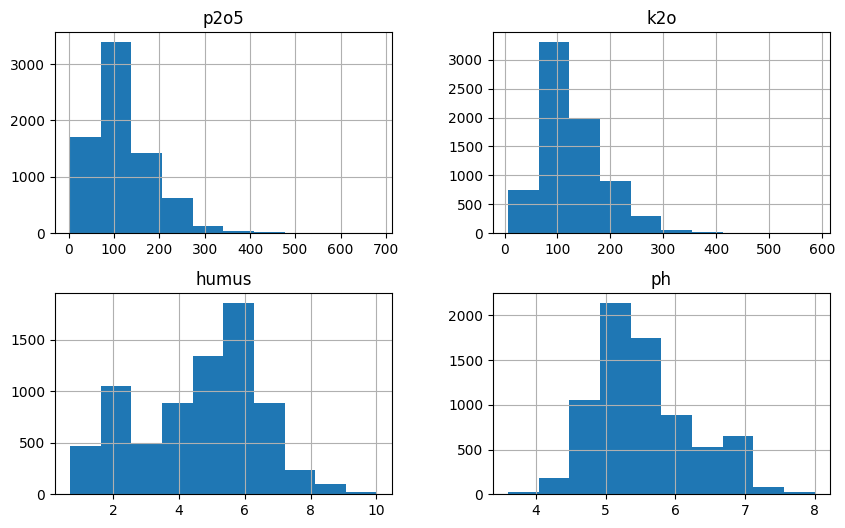

In [154]:
df_main[['p2o5', 'k2o', 'humus', 'ph']].hist(figsize=(10, 6))

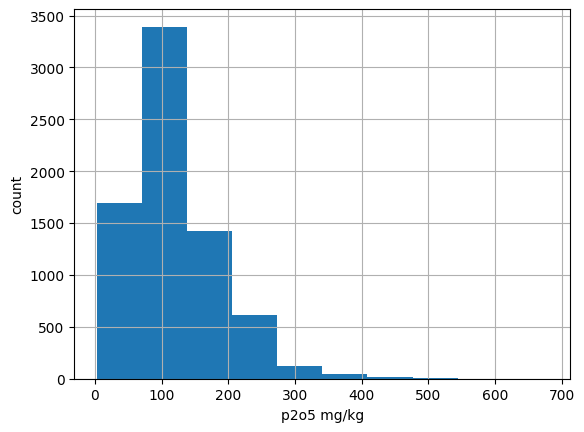

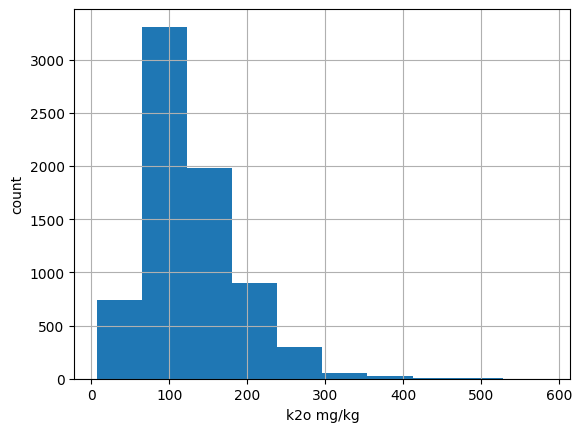

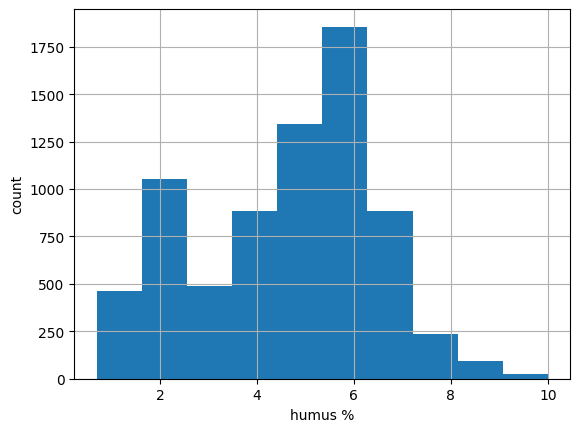

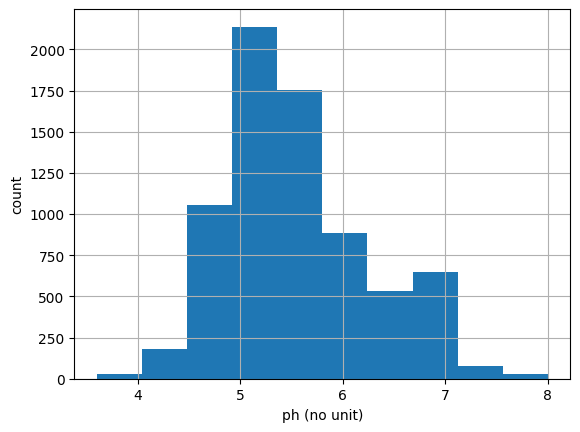

In [155]:
# p2o5
df_main['p2o5'].hist()

plt.xlabel('p2o5 mg/kg')
plt.ylabel('count')

plt.show()

# k2o
df_main['k2o'].hist()

plt.xlabel('k2o mg/kg')
plt.ylabel('count')

plt.show()

# humus
df_main['humus'].hist()

plt.xlabel('humus %')
plt.ylabel('count')

plt.show()

# ph
df_main['ph'].hist()

plt.xlabel('ph (no unit)')
plt.ylabel('count')

plt.show()


### Категориальные признаки

In [156]:
top_crops = df_main['crop'].value_counts().head(5).index.to_list()

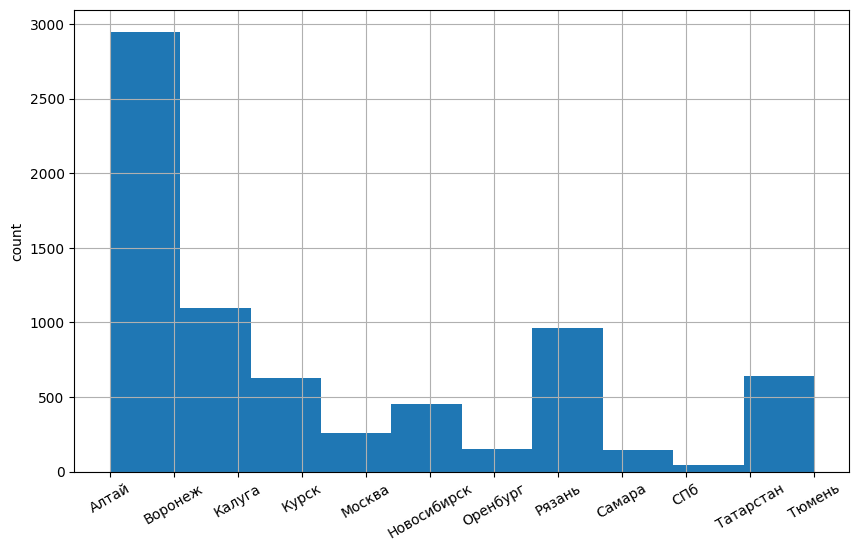

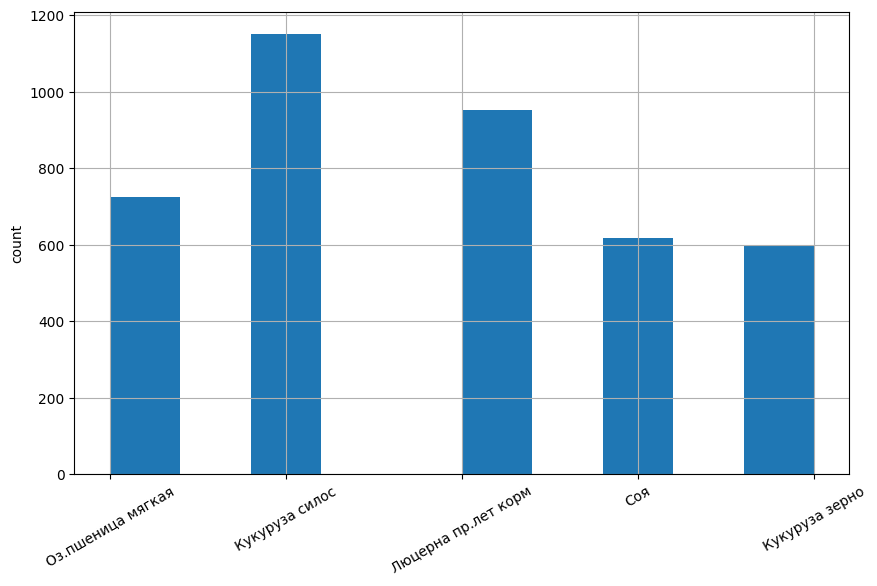

In [157]:
df_main['region'].hist(figsize=(10, 6), xrot=30)

plt.ylabel('count')

plt.show()

df_main.query(f"crop in {top_crops}")['crop'].hist(figsize=(10, 6), xrot=30)

plt.ylabel('count')

plt.show()

### Урожайности

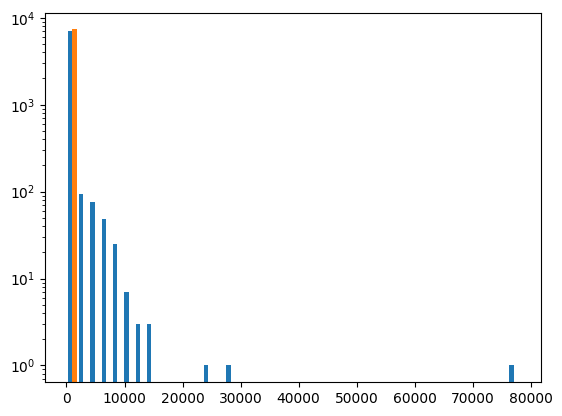

In [158]:
plt.hist([df_main['yield_fact'], df_main['yield_plan']], bins=40)

plt.yscale('log')

plt.show()

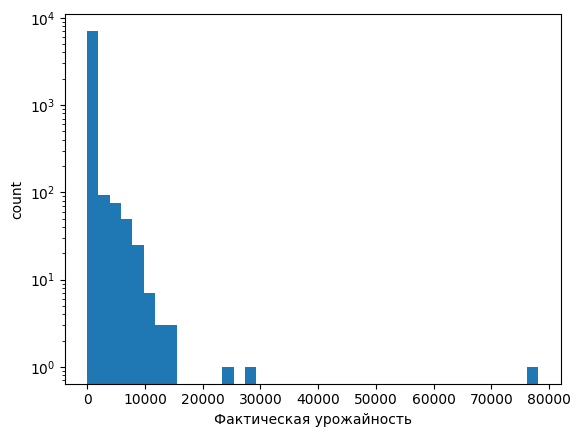

In [159]:
plt.hist(df_main['yield_fact'], bins=40)

plt.yscale('log')

plt.xlabel('Фактическая урожайность')
plt.ylabel('count')

plt.show()

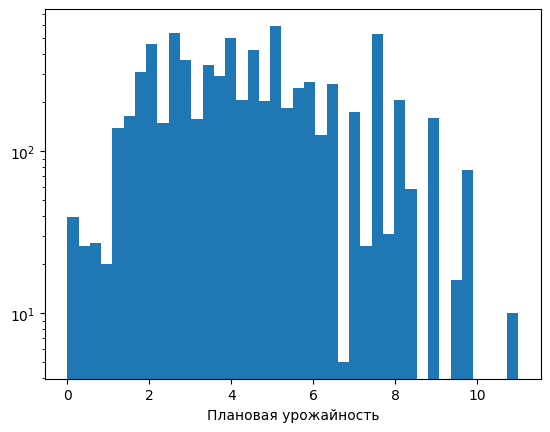

In [160]:
plt.hist(df_main['yield_plan'], bins=40)

plt.yscale('log')

plt.xlabel('Плановая урожайность')

plt.show()

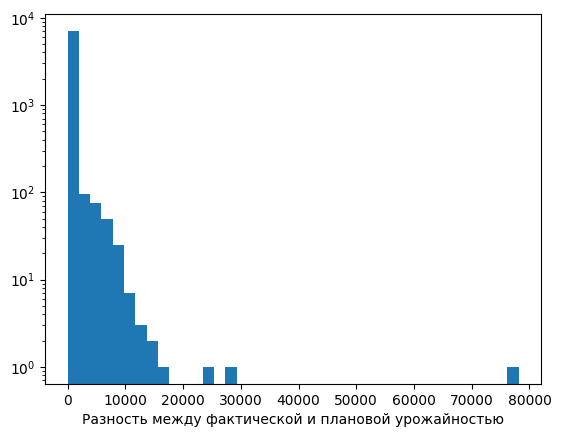

In [161]:
plt.hist(df_main['fact_plan_diff'], bins=40)

plt.yscale('log')

plt.xlabel('Разность между фактической и плановой урожайностью')

plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x762a0c4cff10>,
 'caps': [<matplotlib.lines.Line2D at 0x762a0c4cee00>,
 'boxes': [<matplotlib.lines.Line2D at 0x762a0c4cfbe0>],
 'medians': [<matplotlib.lines.Line2D at 0x762a0c4cfdc0>],
 'fliers': [],
 'means': []}

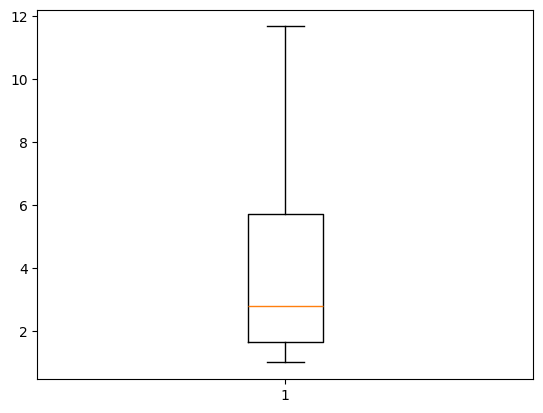

In [162]:
plt.boxplot(df_main[df_main['yield_fact'] > 1]['yield_fact'], showfliers=False)

### ТМЦ и CЗР

In [163]:
df_main['кг_fert'].max()

np.float64(22969875109.48)

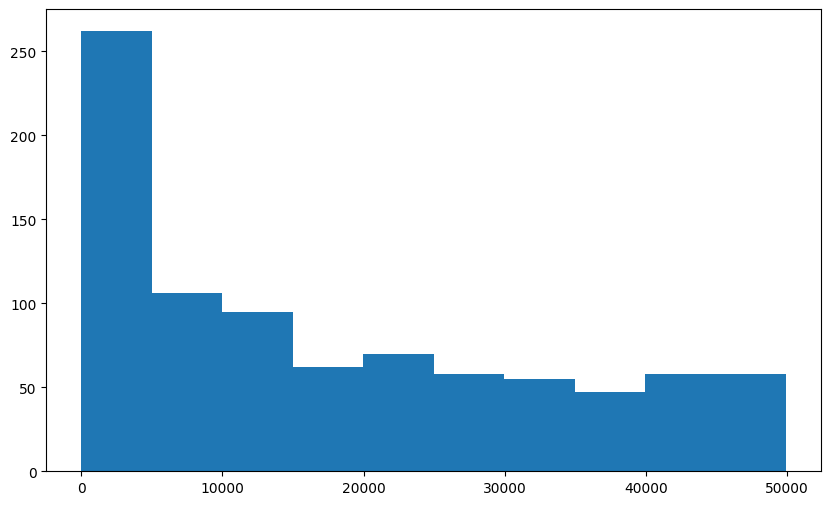

In [164]:
plt.figure(figsize=(10, 6))

# plt.yscale('log')

plt.hist(df_main.query('кг_fert > 0. and кг_fert < 50000')['кг_fert'])

plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x762a0c456ef0>,
 'caps': [<matplotlib.lines.Line2D at 0x762a0c457280>,
 'boxes': [<matplotlib.lines.Line2D at 0x762a0c457250>],
 'medians': [<matplotlib.lines.Line2D at 0x762a0c455f60>],
 'fliers': [],
 'means': []}

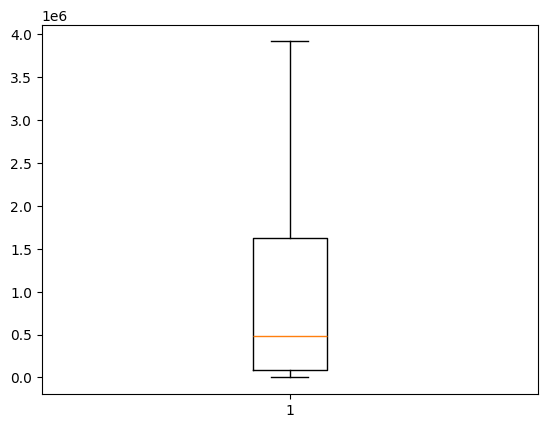

In [165]:
plt.boxplot(df_main.query('кг_fert > 0')['кг_fert'], showfliers=False)

## Чистка

In [166]:
df_main.head()

,season,field,p2o5,k2o,humus,ph,crop,region,yield_plan,yield_fact,кг_fert,л_fert,кг_pp,л_pp,fact_plan_diff
0,2023,22.47.01.001.01,221.05,206.3,4.05,5.25,Оз.пшеница мягкая,Алтай,3.8,190.592405,4457166.035,0.0,13.94,127.390,186.792405
1,2023,22.47.01.003.00,186.50,174.8,5.90,5.40,Оз.пшеница мягкая,Алтай,3.8,1.851617,8226128.065,0.0,20.58,182.256,-1.948383
2,2023,22.47.01.004.00,166.60,147.9,5.60,5.40,Оз.пшеница мягкая,Алтай,3.8,1.418186,4386226.595,0.0,12.27,108.668,-2.381814
3,2023,22.47.01.006.02,194.70,195.9,4.00,5.15,Оз.пшеница мягкая,Алтай,3.8,2.187347,586686.335,0.0,2.89,26.346,-1.612653
4,2023,22.47.01.007.02,184.20,171.4,4.40,5.05,Оз.пшеница мягкая,Алтай,3.8,2.109071,1013707.990,0.0,3.89,35.592,-1.690929


In [167]:
def remove_outliers_iqr(df, columns, k=1.5):
    cleared = df.copy()
    to_drop = []

    for column in columns:
        Q1 = cleared[column].quantile(0.25)
        Q3 = cleared[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - k * IQR
        upper_bound = Q3 + k * IQR

        # Найти индексы выбросов для текущего столбца
        outliers = cleared[(cleared[column] < lower_bound) | (cleared[column] > upper_bound)].index
        to_drop.extend(outliers)

        # Удалить выбросы для текущего столбца
        cleared = cleared[(cleared[column] >= lower_bound) & (cleared[column] <= upper_bound)]

    # Создать DataFrame с выбросами
    to_drop = list(set(to_drop))  # Удалить дубликаты индексов
    outliers_df = df.loc[to_drop]

    return cleared, outliers_df


In [168]:
df_main_clear, df_main_trash = remove_outliers_iqr(df_main, ['yield_fact', 'p2o5', 'k2o'], 1.5)

In [169]:
1 - df_main_clear.shape[0] / df_main.shape[0]

0.11810486073184057

In [170]:
df_main_trash.describe()

,season,p2o5,k2o,humus,ph,yield_plan,yield_fact,кг_fert,л_fert,кг_pp,л_pp,fact_plan_diff
count,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,865.000000,8.650000e+02,8.650000e+02,865.000000,865.000000,865.000000
mean,2023.456647,165.946520,164.006266,4.565572,5.429295,5.221329,1913.600992,2.916627e+07,5.839113e+04,17.321204,157.352470,1908.379662
std,0.498405,109.178462,103.436421,1.656501,0.620194,2.357648,3918.176432,7.810656e+08,1.460581e+06,50.074104,993.515486,3917.450600
min,2023.000000,11.000000,27.000000,0.800000,3.600000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,-8.431687
25%,2023.000000,84.000000,90.000000,3.400000,5.000000,3.400000,3.180000,4.347810e+03,0.000000e+00,0.000000,9.280000,-0.767835
50%,2023.000000,127.000000,127.000000,4.900000,5.300000,5.000000,143.832601,2.672105e+05,0.000000e+00,0.510000,44.996000,137.945845
75%,2024.000000,244.200000,216.880000,5.800000,5.700000,7.500000,2820.410000,1.390173e+06,0.000000e+00,8.660000,115.040000,2814.910000
max,2024.000000,679.000000,586.000000,9.500000,8.000000,11.000000,78114.350000,2.296988e+10,4.293744e+07,562.080000,19129.770000,78106.850000


In [171]:
df_main_clear.to_csv("../data/df_main_clear.csv")
df_main_trash.to_csv("../data/df_main_trash.csv")

## После чистки

### Хим

array([[<Axes: title={'center': 'p2o5'}>,
        <Axes: title={'center': 'k2o'}>],
       [<Axes: title={'center': 'humus'}>,
        <Axes: title={'center': 'ph'}>]], dtype=object)

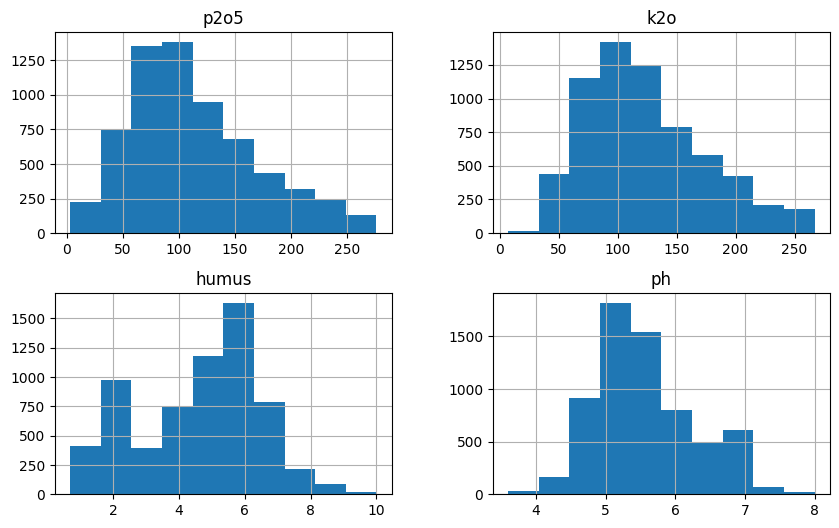

In [172]:
df_main_clear[['p2o5', 'k2o', 'humus', 'ph']].hist(figsize=(10, 6))

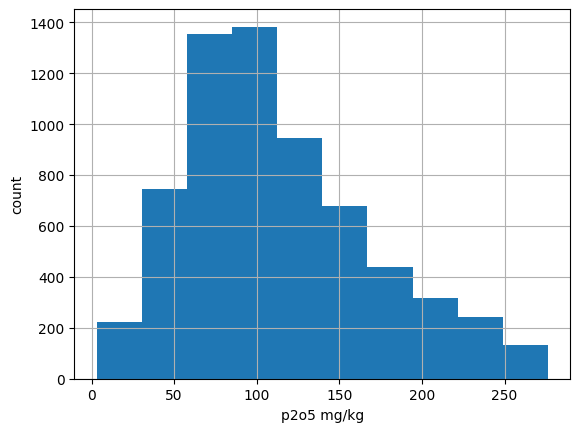

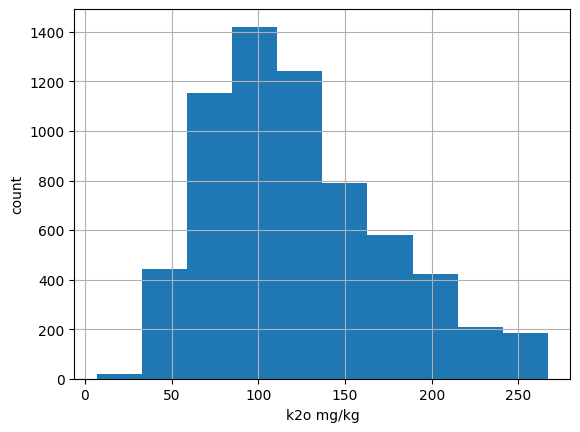

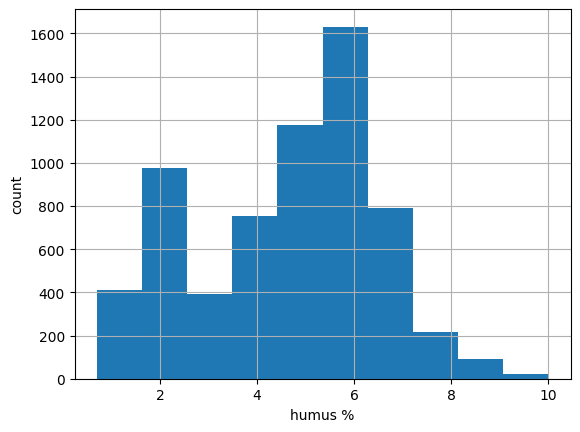

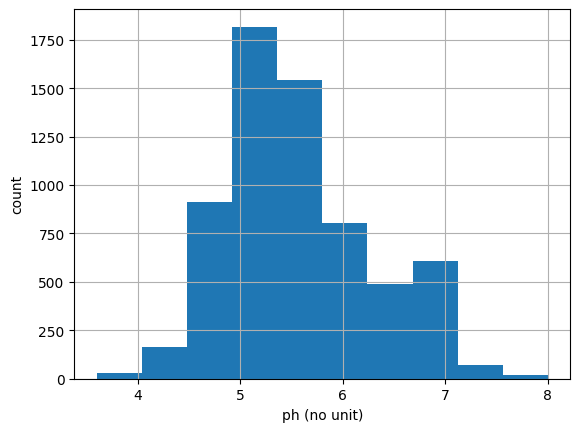

In [173]:
# p2o5
df_main_clear['p2o5'].hist()

plt.xlabel('p2o5 mg/kg')
plt.ylabel('count')

plt.show()

# k2o
df_main_clear['k2o'].hist()

plt.xlabel('k2o mg/kg')
plt.ylabel('count')

plt.show()

# humus
df_main_clear['humus'].hist()

plt.xlabel('humus %')
plt.ylabel('count')

plt.show()

# ph
df_main_clear['ph'].hist()

plt.xlabel('ph (no unit)')
plt.ylabel('count')

plt.show()


### Категориальные признаки

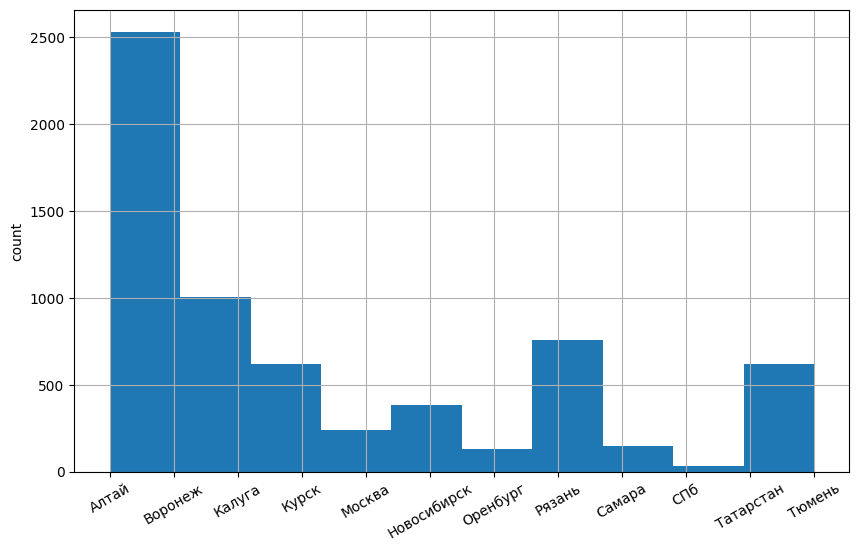

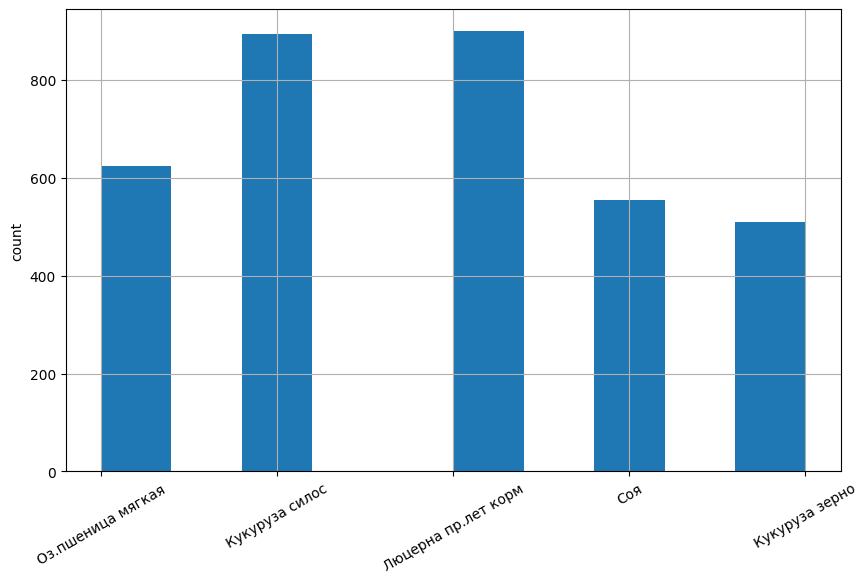

In [174]:
df_main_clear['region'].hist(figsize=(10, 6), xrot=30)

plt.ylabel('count')

plt.show()

df_main_clear.query(f"crop in {top_crops}")['crop'].hist(figsize=(10, 6), xrot=30)

plt.ylabel('count')

plt.show()

### Урожайности

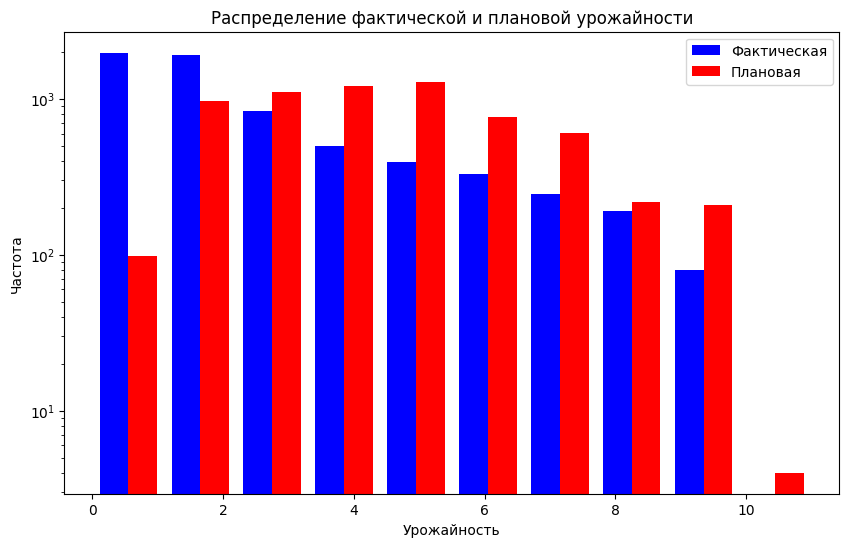

In [175]:
plt.figure(figsize=(10, 6))

plt.hist([df_main_clear['yield_fact'], df_main_clear['yield_plan']], color=['blue', 'red'], label=['Фактическая', 'Плановая'])

plt.yscale('log')

plt.title("Распределение фактической и плановой урожайности")
plt.ylabel("Частота")
plt.xlabel("Урожайность")

plt.legend()

plt.show()

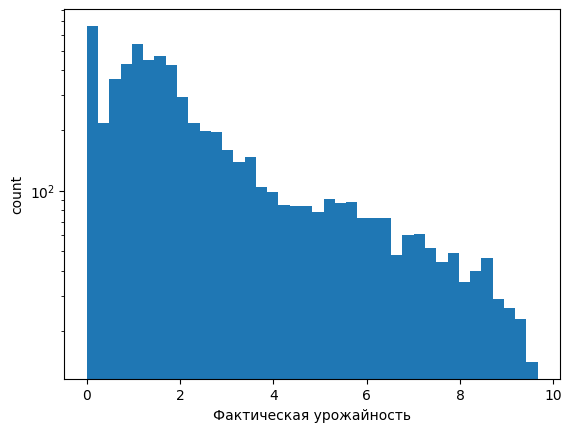

In [176]:
plt.hist(df_main_clear['yield_fact'], bins=40)

plt.yscale('log')

plt.xlabel('Фактическая урожайность')
plt.ylabel('count')

plt.show()

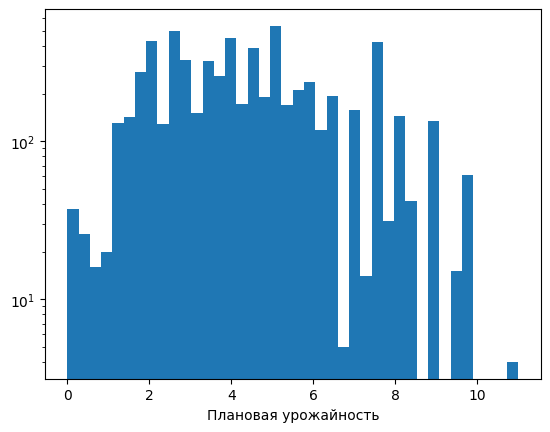

In [177]:
plt.hist(df_main_clear['yield_plan'], bins=40)

plt.yscale('log')

plt.xlabel('Плановая урожайность')

plt.show()

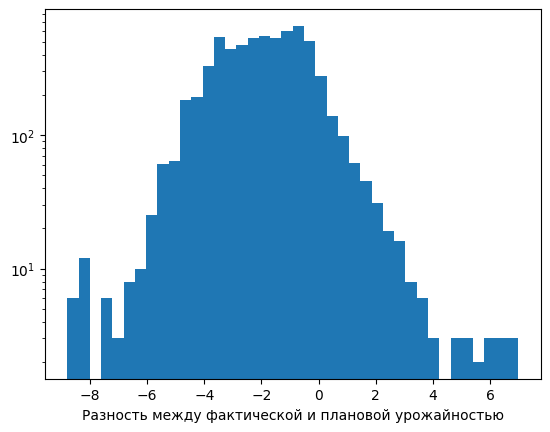

In [178]:
plt.hist(df_main_clear['fact_plan_diff'], bins=40)

plt.yscale('log')

plt.xlabel('Разность между фактической и плановой урожайностью')

plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x762a0bcb3820>,
 'caps': [<matplotlib.lines.Line2D at 0x762a0bcb37c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x762a0bcb1a20>],
 'medians': [<matplotlib.lines.Line2D at 0x762a0bcb0a30>],
 'fliers': [],
 'means': []}

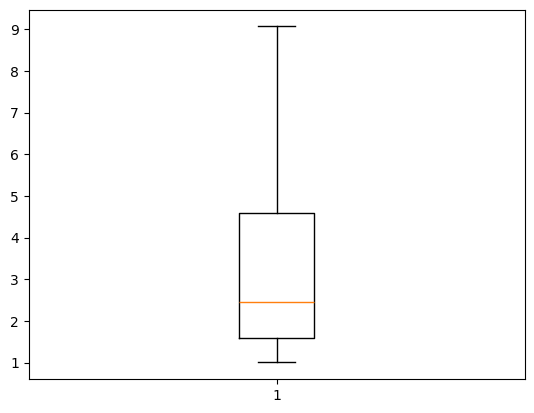

In [179]:
plt.boxplot(df_main_clear[df_main_clear['yield_fact'] > 1]['yield_fact'], showfliers=False)

### ТМЦ и CЗР

In [180]:
df_main_clear['кг_fert'].max()

np.float64(1405217278.8)

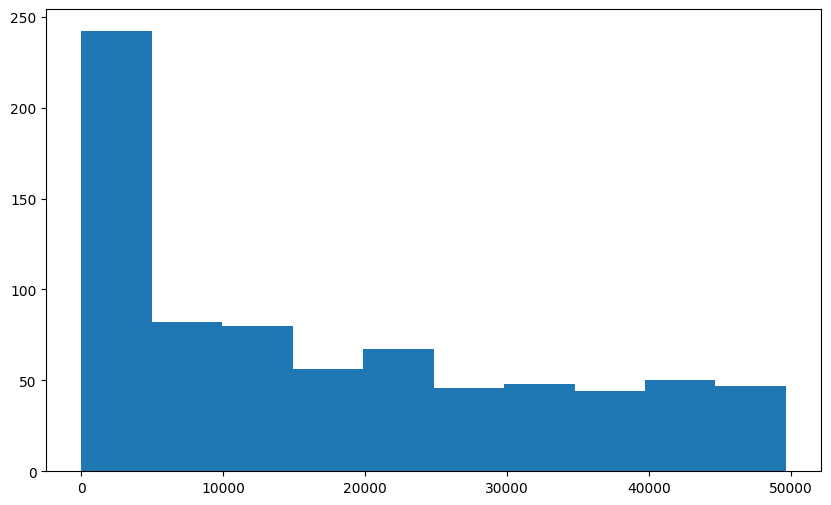

In [181]:
plt.figure(figsize=(10, 6))

# plt.yscale('log')

plt.hist(df_main_clear.query('кг_fert > 0. and кг_fert < 50000')['кг_fert'])

plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x762a0bd83940>,
 'caps': [<matplotlib.lines.Line2D at 0x762a0bd80940>,
 'boxes': [<matplotlib.lines.Line2D at 0x762a0bd82d40>],
 'medians': [<matplotlib.lines.Line2D at 0x762a0bd81900>],
 'fliers': [<matplotlib.lines.Line2D at 0x762a0bd82320>],
 'means': []}

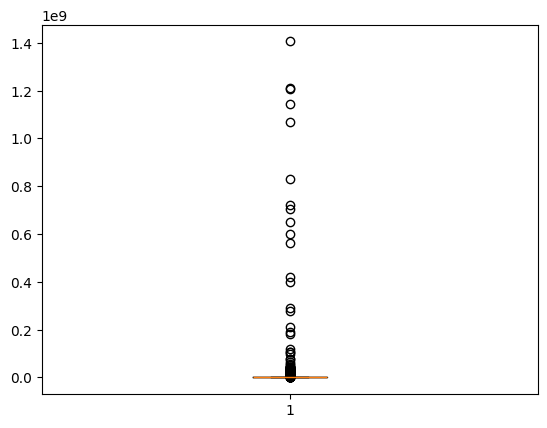

In [182]:
plt.boxplot(df_main_clear.query('кг_fert > 0')['кг_fert'], showfliers=True)

# $R^2$ Для фактичесой - плановой урожайности

In [183]:
from sklearn.metrics import r2_score

In [184]:
y_fact = df_main_clear['yield_fact']
y_pred = df_main_clear['yield_plan']

r2_score(y_fact, y_pred)

-0.2751749911214898

# Важные таблицы

In [185]:
crops = list(df_main_clear['crop'].unique())
regions = list(df_main_clear['region'].unique())

crops.append('Общее')
regions.append('Общее')

In [186]:
import pandas as pd

data = {
    "Колонка1": [1, 2, 3],
    "Колонка2": [4, 5, 6],
    "Колонка3": [7, 8, 9]
}
index_names = ["Строка1", "Строка2", "Строка3"]

df = pd.DataFrame(data, index=index_names)

df


,Колонка1,Колонка2,Колонка3
Строка1,1,4,7
Строка2,2,5,8
Строка3,3,6,9


In [187]:
coffee_r2 = pd.DataFrame(data=np.nan, index=crops, columns=regions)

coffee_r2

,Алтай,Воронеж,Калуга,Курск,Москва,Новосибирск,Оренбург,Рязань,Самара,СПб,Татарстан,Тюмень,Общее
Оз.пшеница мягкая,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Яр.пшеница мягкая,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Кукуруза силос,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Люцерна пр.лет корм,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Одн.тр.(вика+овёс)корм,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Горчица сарептская,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Овёс с подс.(кл.кр+тим.корм),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Одн.тр.сорго-суданский гибрид корм,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Одн.тр.яр.ячмень корм,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [188]:
for region in regions:
    for crop in crops:
        query = ""

        if crop != 'Общее':
            query += f"crop == '{crop}'"
        if region != 'Общее':
            if crop != 'Общее':
                query += " and "
            query += f"region == '{region}'"

        y_fact = []
        y_pred = []

        if len(query) > 0:
            y_fact = df_main_clear.query(query)['yield_fact']
            y_pred = df_main_clear.query(query)['yield_plan']
        else:
            y_fact = df_main_clear['yield_fact']
            y_pred = df_main_clear['yield_plan']

        if y_fact.shape[0] <= 1 or y_pred.shape[0] <= 1:
            continue

        coffee_r2.loc[crop, region] = r2_score(y_fact, y_pred)
        
coffee_r2

,Алтай,Воронеж,Калуга,Курск,Москва,Новосибирск,Оренбург,Рязань,Самара,СПб,Татарстан,Тюмень,Общее
Оз.пшеница мягкая,-9.332499,-1.667403,-7.421434,-8.420398,-4.733755,-0.002220,-7.897788,-7.367581,-224.311359,NaN,-5.647834,-37.733861,-2.197027
Яр.пшеница мягкая,-22.782020,-4.821390,-12.377215,-8.326529,-1.862093,-0.550769,NaN,-4.517728,NaN,NaN,NaN,NaN,-3.567575
Кукуруза силос,-5.365332,-0.663106,-1.076981,NaN,-1.498273,-0.912888,-4.044438,-0.815577,-0.060660,-18.363496,0.358646,-3.912880,-0.539914
Люцерна пр.лет корм,-43.643698,-9.433588,-6.233731,NaN,-120.607619,-54.889148,-3.234513,-23.492661,0.000000,-130.608079,-24.842300,-56.243787,-9.611298
Одн.тр.(вика+овёс)корм,-0.198332,-2.750210,NaN,NaN,NaN,-0.791057,NaN,NaN,NaN,NaN,NaN,0.000000,-0.781492
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Горчица сарептская,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Овёс с подс.(кл.кр+тим.корм),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.029697,-3.029697
Одн.тр.сорго-суданский гибрид корм,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.766915,-0.766915
Одн.тр.яр.ячмень корм,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000


In [189]:
coffee_r2.max().max()

for region in regions:
    for crop in crops:
        if coffee_r2.loc[crop, region] == coffee_r2.max().max():
            print(crop, region)

Общее Алтай


In [190]:
mean_pf_dif = pd.DataFrame(data=np.nan, index=crops, columns=regions)

In [191]:
for region in regions:
    for crop in crops:
        query = ""

        if crop != 'Общее':
            query += f"crop == '{crop}'"
        if region != 'Общее':
            if crop != 'Общее':
                query += " and "
            query += f"region == '{region}'"

        y_fact = []
        y_pred = []

        if len(query) > 0:
            diff = df_main_clear.query(query)['fact_plan_diff']
        else:
            diff = df_main_clear['fact_plan_diff']
        
        mean = diff.mean()

        mean_pf_dif.loc[crop, region] = mean

mean_pf_dif


,Алтай,Воронеж,Калуга,Курск,Москва,Новосибирск,Оренбург,Рязань,Самара,СПб,Татарстан,Тюмень,Общее
Оз.пшеница мягкая,-1.876197,-1.717035,-2.775627,-2.480168,-2.229317,-0.573860,-1.718698,-2.645969,-2.821475,NaN,-2.548508,-2.142308,-2.127753
Яр.пшеница мягкая,-1.591574,-2.258654,-3.314428,-2.178239,-1.085175,-1.224937,NaN,-1.990924,NaN,NaN,NaN,-2.350000,-2.231676
Кукуруза силос,-1.575918,-1.860456,-1.790880,NaN,-1.804236,-3.083552,-2.674544,-0.258972,0.500948,-3.503333,-0.322354,-3.266642,-1.593903
Люцерна пр.лет корм,-2.887986,-3.488080,-3.325733,NaN,-4.508433,-2.655576,-2.342882,-3.416441,-3.400000,-3.710398,-2.936067,-4.759750,-3.417061
Одн.тр.(вика+овёс)корм,-0.560027,-0.805193,NaN,NaN,NaN,-0.856975,NaN,NaN,NaN,NaN,NaN,-3.700000,-1.222553
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Горчица сарептская,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.972667,NaN,NaN,NaN,NaN,-0.972667
Овёс с подс.(кл.кр+тим.корм),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.097494,-1.097494
Одн.тр.сорго-суданский гибрид корм,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.620839,0.620839
Одн.тр.яр.ячмень корм,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.500000,-3.500000


In [192]:
cnt = 0

pos_diff_mean = []

for crop in crops:
    for region in regions:
        if mean_pf_dif.loc[crop, region] > 0:
            print(crop, region, mean_pf_dif.loc[crop, region])
            pos_diff_mean.append([crop, region])
            cnt += 1

cnt

Кукуруза силос Самара 0.5009480830836324
Яр.ячмень Новосибирск 0.17990268193073364
Люцерна 1 г.ж.корм Татарстан 0.23707287952002415
Кукуруза зерно Татарстан 1.887179304888605
Эспарцет пр.лет сем. Воронеж 0.5892307692307691
Эспарцет пр.лет сем. Общее 0.5257142857142856
Кукуруза корнаж Воронеж 4.63
Кукуруза корнаж Калуга 0.2400000000000002
Нут Воронеж 0.685
Кормовые бобы Калуга 0.22843036764762487
Гречиха Рязань 0.2574805447470816
Горох Новосибирск 0.8679119140718458
Райграс пастб.пр.лет сем. Новосибирск 0.005091865466847941
Райграс пастб.пр.лет сем. Общее 0.005091865466847941
Клевер кр.пр.лет сем. Новосибирск 0.20948432785445387
Клевер кр.пр.лет сем. Общее 0.20948432785445387
Клевер бел.пр.лет сем. Новосибирск 0.01532447276300863
Клевер бел.пр.лет сем. Общее 0.01532447276300863
Овёс с подс.(кл.кр.сем.) Новосибирск 1.3612026243336648
Овёс с подс.(кл.кр.сем.) Общее 1.3612026243336648
Одн.тр.(вика+овёс)с подс.(кл.кр.сем)семена Новосибирск 1.0718382829350428
Одн.тр.(вика+овёс)с подс.(кл.кр.

29

In [193]:
count_df = pd.DataFrame(data=np.nan, index=crops, columns=regions)

In [194]:
for region in regions:
    for crop in crops:
        query = ""

        if crop != 'Общее':
            query += f"crop == '{crop}'"
        if region != 'Общее':
            if crop != 'Общее':
                query += " and "
            query += f"region == '{region}'"

        y_fact = []
        y_pred = []

        if len(query) > 0:
            diff = df_main_clear.query(query)['fact_plan_diff']
        else:
            diff = df_main_clear['fact_plan_diff']

        count_df.loc[crop, region] = diff.shape[0]

count_df


,Алтай,Воронеж,Калуга,Курск,Москва,Новосибирск,Оренбург,Рязань,Самара,СПб,Татарстан,Тюмень,Общее
Оз.пшеница мягкая,25.0,195.0,87.0,77.0,73.0,37.0,10.0,53.0,11.0,0.0,52.0,5.0,625.0
Яр.пшеница мягкая,8.0,28.0,115.0,157.0,31.0,50.0,0.0,108.0,0.0,0.0,0.0,1.0,498.0
Кукуруза силос,18.0,324.0,273.0,0.0,59.0,27.0,13.0,60.0,37.0,3.0,64.0,16.0,894.0
Люцерна пр.лет корм,4.0,363.0,177.0,0.0,49.0,70.0,21.0,98.0,39.0,8.0,45.0,26.0,900.0
Одн.тр.(вика+овёс)корм,19.0,11.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,9.0,53.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Горчица сарептская,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
Овёс с подс.(кл.кр+тим.корм),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0
Одн.тр.сорго-суданский гибрид корм,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0
Одн.тр.яр.ячмень корм,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0


In [195]:
for i in pos_diff_mean:
    print(i, count_df.loc[i[0], i[1]])

['Кукуруза силос', 'Самара'] 37.0
['Яр.ячмень', 'Новосибирск'] 20.0
['Люцерна 1 г.ж.корм', 'Татарстан'] 21.0
['Кукуруза зерно', 'Татарстан'] 7.0
['Эспарцет пр.лет сем.', 'Воронеж'] 13.0
['Эспарцет пр.лет сем.', 'Общее'] 14.0
['Кукуруза корнаж', 'Воронеж'] 3.0
['Кукуруза корнаж', 'Калуга'] 1.0
['Нут', 'Воронеж'] 4.0
['Кормовые бобы', 'Калуга'] 10.0
['Гречиха', 'Рязань'] 4.0
['Горох', 'Новосибирск'] 32.0
['Райграс пастб.пр.лет сем.', 'Новосибирск'] 3.0
['Райграс пастб.пр.лет сем.', 'Общее'] 3.0
['Клевер кр.пр.лет сем.', 'Новосибирск'] 5.0
['Клевер кр.пр.лет сем.', 'Общее'] 5.0
['Клевер бел.пр.лет сем.', 'Новосибирск'] 4.0
['Клевер бел.пр.лет сем.', 'Общее'] 4.0
['Овёс с подс.(кл.кр.сем.)', 'Новосибирск'] 1.0
['Овёс с подс.(кл.кр.сем.)', 'Общее'] 1.0
['Одн.тр.(вика+овёс)с подс.(кл.кр.сем)семена', 'Новосибирск'] 2.0
['Одн.тр.(вика+овёс)с подс.(кл.кр.сем)семена', 'Общее'] 2.0
['Эспарцет пр.лет корм', 'Татарстан'] 13.0
['Одн.тр(оз.тритикале+оз.вика) семена', 'Воронеж'] 3.0
['Одн.тр.суданская

In [196]:
shapiro_df = pd.DataFrame(data=np.nan, index=crops, columns=regions)

In [197]:
from scipy.stats import shapiro

In [198]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    for region in regions:
        for crop in crops:
            query = ""

            if crop != 'Общее':
                query += f"crop == '{crop}'"
            if region != 'Общее':
                if crop != 'Общее':
                    query += " and "
                query += f"region == '{region}'"

            y_fact = []
            y_pred = []

            if len(query) > 0:
                diff = df_main_clear.query(query)['fact_plan_diff']
            else:
                diff = df_main_clear['fact_plan_diff']

            shapiro_df.loc[crop, region] = shapiro(diff)[1]

shapiro_df


,Алтай,Воронеж,Калуга,Курск,Москва,Новосибирск,Оренбург,Рязань,Самара,СПб,Татарстан,Тюмень,Общее
Оз.пшеница мягкая,0.401650,2.344584e-07,6.236567e-01,0.039401,0.000052,1.316178e-03,0.074229,1.971835e-02,4.630352e-01,NaN,0.000085,0.566729,2.105419e-08
Яр.пшеница мягкая,0.519997,3.326261e-02,4.495077e-07,0.000665,0.034939,8.954630e-07,NaN,2.023679e-05,NaN,NaN,NaN,NaN,1.050253e-10
Кукуруза силос,0.039624,8.265470e-09,1.331745e-05,NaN,0.007166,6.223118e-04,0.165671,2.727727e-02,3.457048e-01,0.133630,0.400775,0.279384,8.903659e-12
Люцерна пр.лет корм,0.166459,7.235789e-16,3.566432e-12,NaN,0.000008,1.161898e-01,0.000004,5.730469e-06,1.000000e+00,0.079485,0.001815,0.082160,3.018255e-20
Одн.тр.(вика+овёс)корм,0.157336,9.183395e-01,NaN,NaN,NaN,3.406252e-01,NaN,NaN,NaN,NaN,NaN,0.000153,8.680238e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Горчица сарептская,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Овёс с подс.(кл.кр+тим.корм),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.097341,9.734136e-02
Одн.тр.сорго-суданский гибрид корм,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.875123,8.751231e-01
Одн.тр.яр.ячмень корм,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000e+00


In [215]:
shapiro(df_main_clear['fact_plan_diff'][:3000:10])

ShapiroResult(statistic=np.float64(0.9753596297929341), pvalue=np.float64(4.966063292537753e-05))

<Axes: >

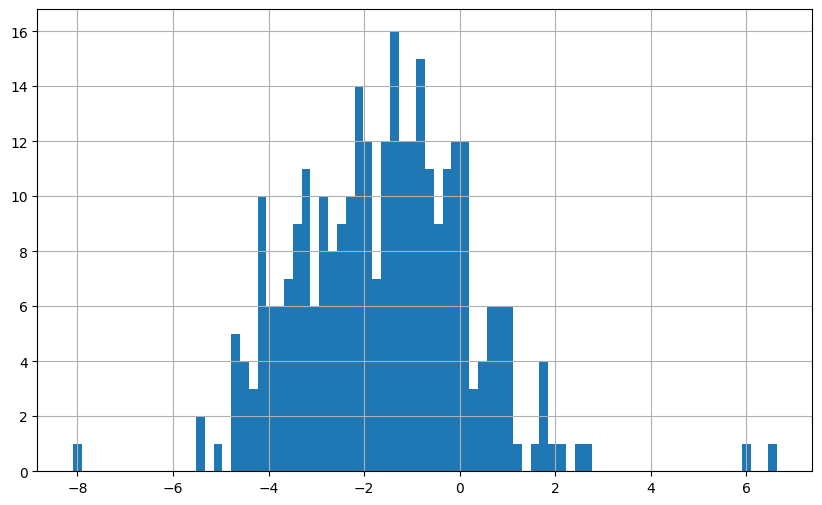

In [216]:
df_main_clear['fact_plan_diff'][:3000:10].hist(bins=80, figsize=(10, 6))

<Axes: >

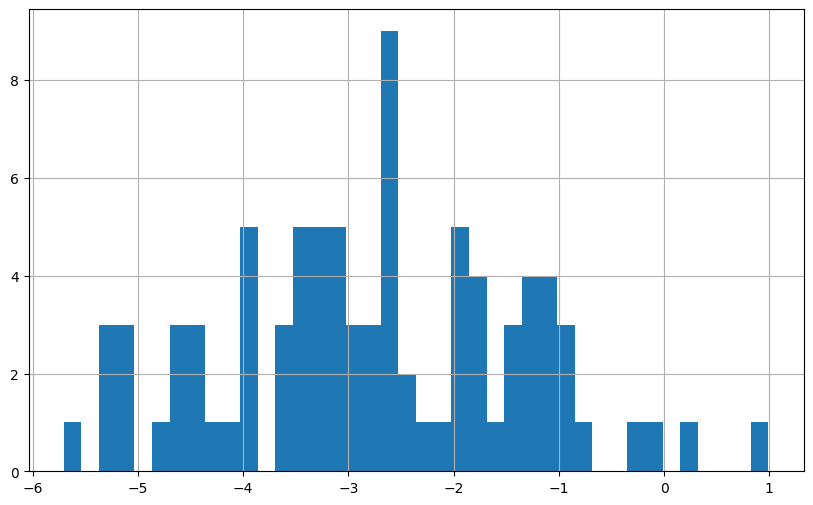

In [201]:
df_main_clear.query("region == 'Калуга' and crop == 'Оз.пшеница мягкая'")['fact_plan_diff'].hist(bins=40, figsize=(10, 6))

In [202]:
from scipy.stats import spearmanr

In [203]:
spearmen_df = pd.DataFrame(data=np.nan, index=crops, columns=regions)

In [209]:
# import warnings

# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")

#     for region in regions:
#         for crop in crops:
#             query = ""

#             if crop != 'Общее':
#                 query += f"crop == '{crop}'"
#             if region != 'Общее':
#                 if crop != 'Общее':
#                     query += " and "
#                 query += f"region == '{region}'"

#             if len(query) > 0:
#                 fact = df_main_clear.query(query)['yield_fact']
#             else:
#                 diff = df_main_clear['yield_fact']

#             spearmen_df.loc[crop, region] = spearmanr(diff)[1]

# spearmen_df
